## 코드 실행환경

Google Colab

Sklearn 버전: 1.2.2

Pandas 버전: 1.5.3

Numpy 버전: 1.23.5

런타임 유형 : CPU

In [1]:
import platform
platform.platform()

'Linux-5.15.120+-x86_64-with-glibc2.35'

In [2]:
!cat /etc/issue.net

Ubuntu 22.04.2 LTS


In [3]:
!python --version

Python 3.10.12


In [4]:
import sklearn
import pandas as pd
import numpy as np

print("Scikit-learn 버전:", sklearn.__version__)
print("Pandas 버전:", pd.__version__)
print("NumPy 버전:", np.__version__)

Scikit-learn 버전: 1.2.2
Pandas 버전: 1.5.3
NumPy 버전: 1.23.5


### 구글 코랩 사용시 구글 드라이브 연결 사용

In [5]:
#구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

#코랩 환경 경로 설정 -> 자신에게 맞는 경로로 설정해주시면 됩니다
DATA_PATH = '/content/drive/MyDrive/HD본선/data/'

Mounted at /content/drive


## Import & Install

In [6]:
# 코랩 기준 필요 라이브러리 설치

#!pip install catboost
#!pip install optuna

In [7]:
# Base & visualization
import pandas as pd
import random
import glob
import os
import numpy as np
import warnings
import matplotlib.pylab as plt
import seaborn as sns

# sklearn module & utils
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# Encoding
from sklearn.preprocessing import LabelEncoder

# Modeling
from xgboost.sklearn import XGBRegressor
#from catboost import CatBoostRegressor
from lightgbm import early_stopping, log_evaluation, LGBMRegressor


#Scaling
#from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# optuna
#import optuna
#from optuna.samplers import TPESampler

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 100)

## Fix Seed

In [8]:
class CFG:
    SEED = 0

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG.SEED) # Seed 고정

## Data Load

In [9]:
train_paths = glob.glob(DATA_PATH + 'train/*.csv')
test_paths = glob.glob(DATA_PATH + 'test/*.csv')

In [10]:
# 성능 재현을 위한 데이터의 로드 순서 고정
train_paths.sort()
test_paths.sort()

## EDA

In [ ]:
1. train_eda = train_paths를 concat한다.
2. 시간별로 변수한다
3. 피처간 상관관계
4. box.plot 하나조지자
5.

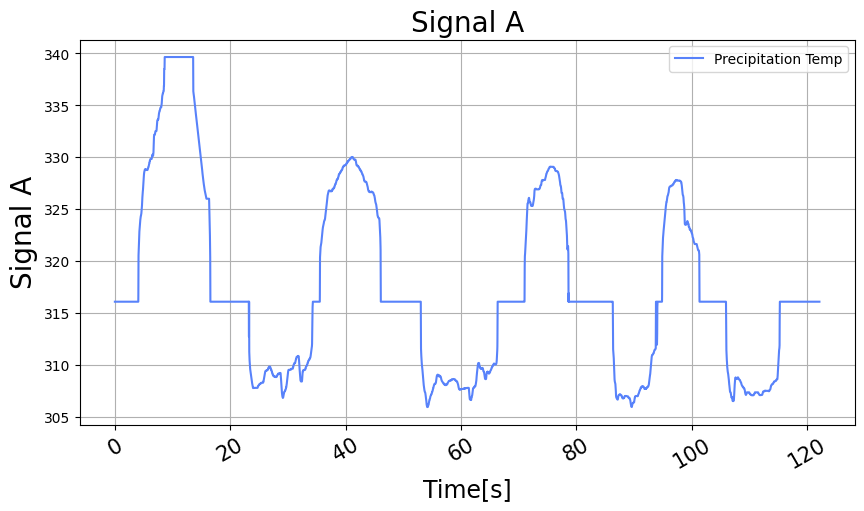

In [ ]:
#시각화
plt.figure(figsize=(10, 5))
sns.lineplot(x=pd.read_csv(train_paths[10])['Time[s]'], y=pd.read_csv(train_paths[10])['Signal A'], data=pd.read_csv(train_paths[0]), label='Precipitation Temp', color = '#5882FA')

plt.title('Signal A',fontsize=20)
plt.xlabel('Time[s]',fontsize=17)
plt.xticks(fontsize = 15 , rotation = 30)
plt.ylabel('Signal A',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

## Feature Engineering

In [ ]:
extremes = {
    'Time': {'min': float('inf'), 'max': float('-inf')},
    'Signal A': {'min': float('inf'), 'max': float('-inf')},
    'Signal B': {'min': float('inf'), 'max': float('-inf')},
    'Signal C': {'min': float('inf'), 'max': float('-inf')},
    'Sensor A': {'min': float('inf'), 'max': float('-inf')},
    'Sensor B': {'min': float('inf'), 'max': float('-inf')},
    'Sensor C': {'min': float('inf'), 'max': float('-inf')},
    'Sensor D': {'min': float('inf'), 'max': float('-inf')}
}

# 주어진 모든 경로에 대해 반복
for path in train_paths:
    data = pd.read_csv(path)
    data = data.rename(columns={'Time[s]': 'Time'})

    # 각 열에 대해 최소값과 최대값 업데이트
    for column in extremes.keys():
        extremes[column]['min'] = min(extremes[column]['min'], data[column].min())
        extremes[column]['max'] = max(extremes[column]['max'], data[column].max())

In [ ]:
train_data = []
test_data = []

for path in tqdm(train_paths):
  data = pd.read_csv(path)
  data = data.rename(columns={'Time[s]': 'Time'}) # 특수문자 제거

  driver = str(path.split('/')[-1].split('.')[0].split('_')[1][0])
  data['driver'] = 0 if driver == 'A' else 1

  label = float(path.split('/')[-1].split('.')[0].split('_')[0][:-2])
  data['label'] = label

  for i, key in enumerate(extremes.keys()):
    data[key] = (data[key] - extremes[key]['min']) / (extremes[key]['max'] - extremes[key]['min']) # 스케일링 진행

  window_size = 500

  # for column in extremes.keys():
  #   data[f'{column}_MA'] = data[column].rolling(window=window_size, min_periods=1).mean() # 500일 이동평균성 피처생성

  data = [data[i:i+window_size] for i in range(0, len(data), window_size)] # 시계열성 반영을 위해 500개씩 Slice

  train_data.append(data)

for path in tqdm(test_paths):
  data = pd.read_csv(path)
  data = data.rename(columns={'Time[s]': 'Time'}) # 특수문자 제거

  driver = str(path.split('/')[-1].split('.')[0].split('_')[1][0])
  data['driver'] = 0 if driver == 'A' else 1

  name = str(path.split('/')[-1].split('_')[0])
  data['ID'] = name

  for i, key in enumerate(extremes.keys()):
    data[key] = (data[key] - extremes[key]['min']) / (extremes[key]['max'] - extremes[key]['min']) # 스케일링 진행

  window_size = 500

  # for column in extremes.keys():
  #   data[f'{column}_MA'] = data[column].rolling(window=window_size, min_periods=1).mean() # 500일 이동평균성 피처생성

  test_data.append(data)

100%|██████████| 4048/4048 [01:28<00:00, 45.51it/s]


In [ ]:
# 각 Train csv별 Slice된 갯수
for i in range(len(train_data)):
  print(i, ':', len(train_data[i]))

0 : 22
1 : 21
2 : 49
3 : 24
4 : 20
5 : 19
6 : 22
7 : 22
8 : 23
9 : 20
10 : 25
11 : 23
12 : 21
13 : 32
14 : 25
15 : 24


## Train_Validation_split

In [ ]:
# Train.csv별 균일하게 validation을 구축

split_ratio = 0.8

X_train = []
X_val = []
for i in range(len(train_data)):
  np.random.seed(CFG.SEED)
  np.random.shuffle(train_data[i])

  split_index = int(len(train_data[i]) * split_ratio)
  X_train.append(pd.concat(train_data[i][:split_index]))
  X_val.append(pd.concat(train_data[i][split_index:]))

In [ ]:
X_train = pd.concat(X_train).reset_index(drop=True)
X_val = pd.concat(X_val).reset_index(drop=True)

test = pd.concat(test_data).reset_index(drop=True)

In [ ]:
y_train = X_train['label']
y_val = X_val['label']

X_train = X_train.drop(columns='label')
X_val = X_val.drop(columns='label')

In [ ]:
test_id = test['ID']
test = test.drop(columns='ID')

## Modeling

In [ ]:
model = LGBMRegressor(n_estimators=100000, learning_rate=0.1, random_state=CFG.SEED, num_leaves=65)
model.fit(X_train, y_train, eval_set=(X_val,y_val), eval_metric='mae', callbacks=[early_stopping(stopping_rounds=1000), log_evaluation(1000)])
pred = model.predict(X_val)
pred = np.clip(pred, 0, np.inf)

mae = mean_absolute_error(y_val, pred)

print(f'MAE는 {mae}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2039
[LightGBM] [Info] Number of data points in the train set: 150437, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 456.049828
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's l1: 130.177	valid_0's l2: 35981.9
[2000]	valid_0's l1: 129.024	valid_0's l2: 35794.5
[3000]	valid_0's l1: 128.696	valid_0's l2: 35757.5
[4000]	valid_0's l1: 128.528	valid_0's l2: 35710.8
[5000]	valid_0's l1: 128.481	valid_0's l2: 35720.2
Early stopping, best iteration is:
[4119]	valid_0's l1: 128.481	valid_0's l2: 35697.9
MAE는 128.4499771250949


In [ ]:
sub_pred = model.predict(test)
sub_pred = np.clip(sub_pred, 0, np.inf)
sub_pred = np.array(sub_pred)

In [ ]:
test['ID'] = test_id
test['weight'] = sub_pred

## Submission

In [ ]:
submit= pd.read_csv(DATA_PATH + 'sample_submission.csv')['ID']

In [ ]:
test_pivot = pd.pivot_table(test, values = 'weight', index='ID', aggfunc=lambda x: np.percentile(x, 24.5)).reset_index()

In [ ]:
submission = pd.merge(submit, test_pivot, how='left', on='ID')

In [ ]:
submission['weight'] = submission['weight'].apply(lambda x: round(x, -2))

In [ ]:
submission.to_csv(DATA_PATH + 'Final_submission.csv', index=False)